# Column info

| Field           | Description                                                                                           |
|-----------------|-------------------------------------------------------------------------------------------------------|
| step            | A unit of time in the real world, where 1 step represents 1 hour. Total steps in the simulation: 744 |
| type            | Type of transaction: CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER                                      |
| amount          | Amount of the transaction in local currency                                                            |
| nameOrig        | Customer who initiated the transaction                                                                  |
| oldbalanceOrg   | Initial balance before the transaction                                                                 |
| newbalanceOrig  | New balance after the transaction                                                                      |
| nameDest        | Recipient of the transaction                                                                           |
| oldbalanceDest  | Initial balance of the recipient before the transaction                                                |
| newbalanceDest  | New balance of the recipient after the transaction                                                     |
| isFraud         | Indicates whether the transaction is fraudulent or not                                                 |
| isFlaggedFraud  | Flags illegal attempts: An attempt to transfer more than $200,000 in a single transaction             |


# Required Dependencies

In [2]:
import pandas as pd

import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance, partial_dependence

# Import sklearn objects
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Tree helper libraries
from sklearn import tree
from io import StringIO
import pydotplus

# Import ensemble objects
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Import plotting libraries
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, precision_score, cohen_kappa_score, PrecisionRecallDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Exploratory Data Analysis

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Credit Card Fraud/Fraud.csv')
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [5]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
data['nameDest'].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: nameDest, Length: 2722362, dtype: int64

In [8]:
data['nameOrig'].value_counts()

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64

In [9]:
columns = ['type', 'isFraud', 'isFlaggedFraud']

In [10]:
def bar_plot(columns):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        data[column].value_counts().plot.bar(ax=axes[i])
        axes[i].set_title(column)

    plt.tight_layout()
    plt.show()

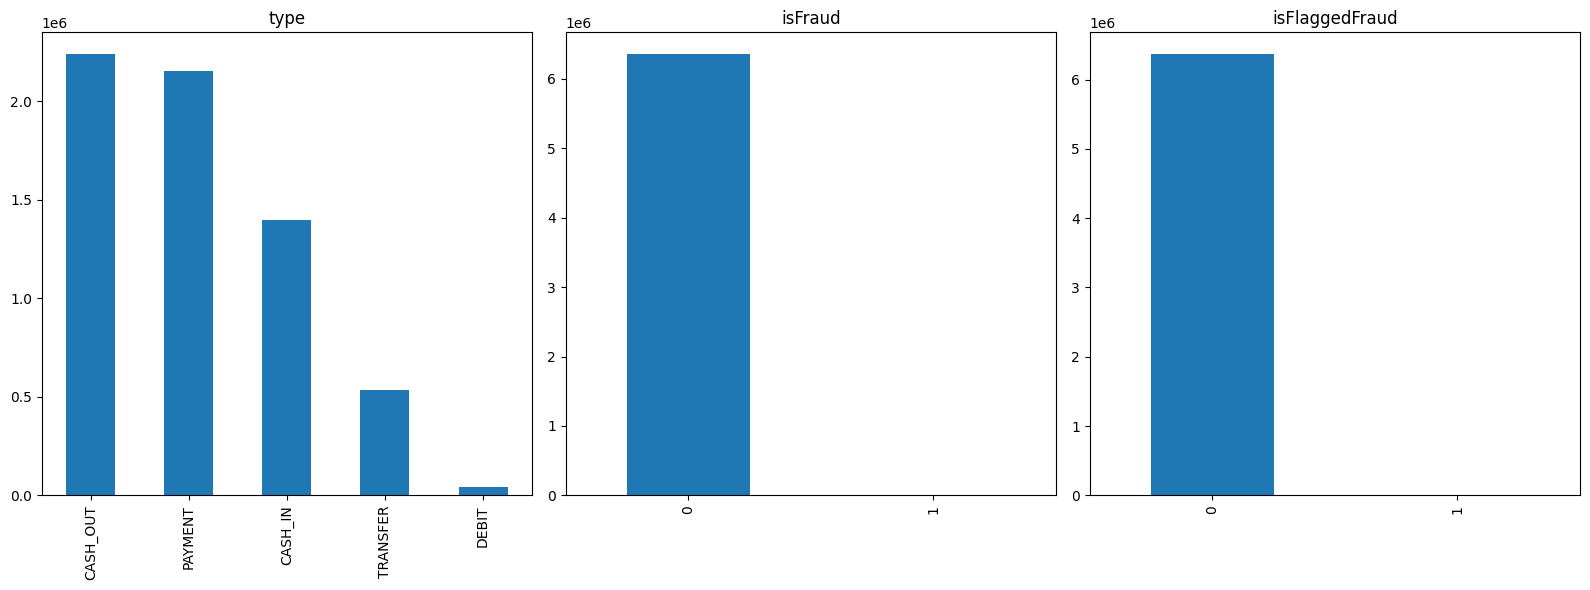

In [11]:
bar_plot(columns)

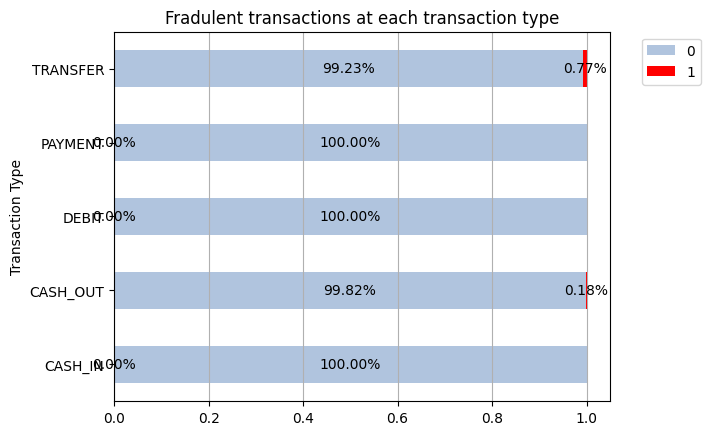

In [12]:
df2 = data.groupby(['type', 'isFraud']).size().unstack()
df2 = df2.div(df2.sum(axis=1), axis=0)
fig = df2.plot(kind='barh', stacked=True, color=['lightsteelblue', 'red'])


for container in fig.containers:
    # Annotate the bars with percentages
    fig.bar_label(container, labels=[f'{x*100:.2f}%' for x in container.datavalues], label_type='center')

fig.set_title('Fradulent transactions at each transaction type')
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.set_ylabel('Transaction Type')
fig.grid(axis='x')  # Change to grid along the x-axis

In [13]:
print('The dataset contains {} non-fraudulent and {} fraudulent transactions. \nThe ration of fraudulent to non fraudulent transactions is 1:{}.'.format(data['isFraud'].value_counts()[0], data['isFraud'].value_counts()[1], int(data['isFraud'].value_counts()[0]/data['isFraud'].value_counts()[1])))

The dataset contains 6354407 non-fraudulent and 8213 fraudulent transactions. 
The ration of fraudulent to non fraudulent transactions is 1:773.


## Choice of metrics for imbalanced datasets

This dataset exhibits a common characteristic of credit fraud transactions: high class imbalance. Given this imbalance, relying on accuracy for evaluating model performance is not advisable. Instead, our primary objective should be to ensure that the model effectively identifies all instances of fraud. While allowing some false positives is acceptable, missing any fraudulent transactions can have significant consequences. Therefore, our baseline expectation is for the model to have high recall in detecting fraud, prioritizing sensitivity over precision.

Another metric that can be used to evaluate the performance of the models is Cohen's Kappa. Cohen's Kappa is a statistical measure used to assess the level of agreement between two raters or classifiers. In the context of machine learning, Cohen's Kappa is often used as an evaluation metric for classification tasks, especially when dealing with imbalanced datasets. This markdown discusses Cohen's Kappa and why it is preferred for imbalanced datasets.

Cohen's Kappa is derived from the concept of observed agreement and expected agreement. It measures the agreement between the observed accuracy and the expected accuracy, correcting for the possibility of the agreement occurring by chance.

The formula for Cohen's Kappa is:
\[ \kappa = \frac{P_o - P_e}{1 - P_e} \]

Where:
- \( P_o \) is the observed accuracy (the proportion of instances on which both raters agree).
- \( P_e \) is the expected accuracy (the probability that both raters agree by chance).

Cohen's Kappa ranges from -1 to 1, where:
- Values close to 1 indicate a high level of agreement beyond chance.
- Values close to 0 suggest no agreement beyond chance.
- Negative values indicate agreement worse than chance.

### Advantages of Cohen's Kappa for Imbalanced Datasets

1. Accounts for Class Imbalance:

In imbalanced datasets, where one class is significantly more prevalent than the other(s), accuracy alone can be misleading. Cohen's Kappa considers the agreement beyond chance, making it less sensitive to class imbalance.

2. Penalizes Misclassifications Differently:

Cohen's Kappa penalizes false positives and false negatives differently. It weighs disagreements based on the marginal totals, providing a more nuanced assessment of classifier performance.

3. Provides a Balanced Assessment:

Since Cohen's Kappa considers both observed and expected agreement, it provides a balanced assessment of classifier performance, taking into account the complexities of imbalanced datasets.

## Synthetic Oversampling

We can use ovesampling techniques to bridge the imbalance of the data. SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to address class imbalance in machine learning datasets, particularly in classification tasks where one class is significantly more prevalent than the others. It works by generating synthetic samples for the minority class to balance out the class distribution.

# 2. Preprocessing

## a. OneHotEncoding

In [14]:
data = pd.concat([data, pd.get_dummies(data['type']).astype(int)], axis=1)
data = data.drop(columns=['type'])
data

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0,1,0,0,0
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0,0,0,0,1
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0,1,0,0,0
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0,0,0,0,1


## b. Training and Test split

In [15]:
X = data.loc[:, ~data.columns.isin(['isFraud', 'nameDest', 'nameOrig'])]

In [16]:
X

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,1,0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,1,0
2,1,181.00,181.00,0.00,0.00,0.00,0,0,0,0,0,1
3,1,181.00,181.00,0.00,21182.00,0.00,0,0,1,0,0,0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,0,0,1,0,0,0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,0,0,0,0,0,1
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,0,0,1,0,0,0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,0,0,0,0,0,1


In [17]:
y = data['isFraud']

Since we are not generating new data, its fine to undersample before we split into train and test.

In [18]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)

# 3. Modelling

In [20]:
def evaluate(yt, yp, eval_type):
    results_pos = {}
    results_pos['type'] = eval_type
    # Cohen's Kappa
    results_pos['cohen\'s kappa'] = cohen_kappa_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    # Recall
    results_pos['recall'] = recall
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta

    results_pos['accuracy'] = accuracy_score(yt, yp)
    return results_pos

In [21]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(results)
    x = np.arange(5)
    # define a color canvas
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    # this array will be used for plotting the different models next to each other.
    n = df.shape[0] # number of models to be plotted
    width = 1/(n+0.4)
    x_ticks = np.arange(-((n-1)//2), -((n-1)//2) + (n), 1)*width
    plt.figure(figsize=(18, 10), dpi=80)
    for i in range(n):
        bars = plt.bar(x+x_ticks[i], df.iloc[i,1:].values, width, color=colors[i])
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=12)
    plt.xticks(x, ['Cohen\'s Kappa', 'Recall', 'Precision', 'F1-score', 'Accuracy'])
    plt.yticks(np.arange(0,1.1,0.1))
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(df.type, loc='center right')
    plt.grid(which='major', axis='y', linestyle='-')
    plt.axhline(y=0.95, color='red', linestyle='-', zorder=0)
    plt.show()

In [22]:
def rp_curve(yt, yp):
    display = PrecisionRecallDisplay.from_predictions(yt, yp, plot_chance_level=True)
    _ = display.ax_.set_title("2-class Precision-Recall curve")
    plt.show()

Initialize the list

In [23]:
results = []

## a. Base Line Model

In [24]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

result = evaluate(y_test, y_pred, 'SVM')
results.append(result)

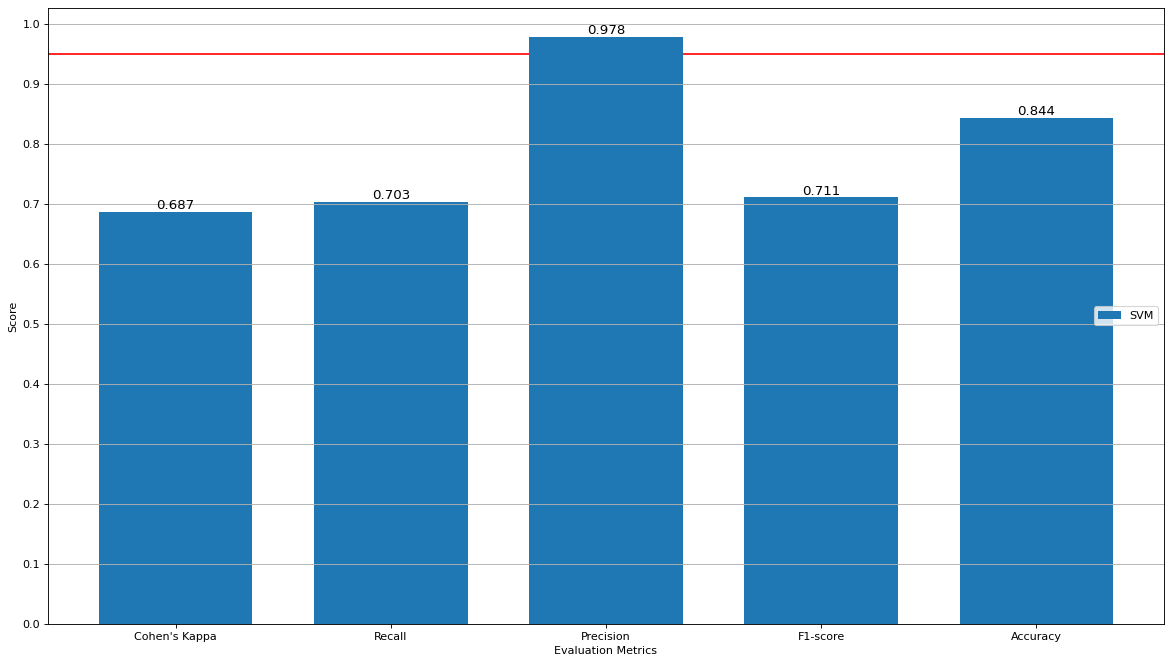

In [25]:
visualize_eval_metrics(results)

## b. Random Forrest

One of the strengths of Random Forest is its capability to handle categorical data effectively. Hence, we could consider utilizing the 'nameDest' and 'nameOrig' columns in our analysis. However, incorporating these features might lead to overfitting the model to the dataset. Consequently, I chose to keep the existing features to have a mode realistic testing accuracy.

In [26]:
RF = RandomForestClassifier(oob_score=True, random_state=0, warm_start=True, n_jobs=-1)

oob_list = list() # create this list to keep track of the OOB error

for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    # Define the number of trees of the model
    RF.set_params(n_estimators=n_trees)
    RF.fit(X_train, y_train)
    oob_error = 1 - RF.oob_score_ # calculate the error
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[Text(0, 0.5, 'out-of-bag error')]

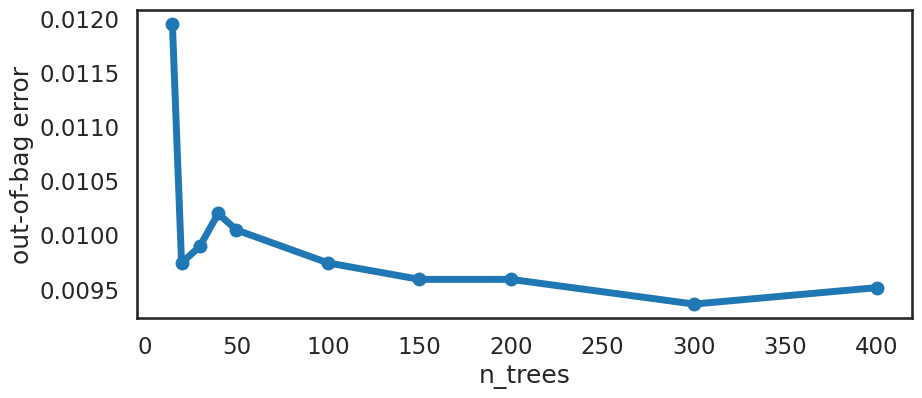

In [27]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(10, 4), linewidth=5)
ax.set(ylabel='out-of-bag error')

In [28]:
RF = RandomForestClassifier(oob_score=True, random_state=0, warm_start=True, n_jobs=-1, max_depth=10, n_estimators=200, min_samples_leaf=2, min_samples_split=5)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

result = evaluate(y_test, y_pred, 'RF')
results.append(result)

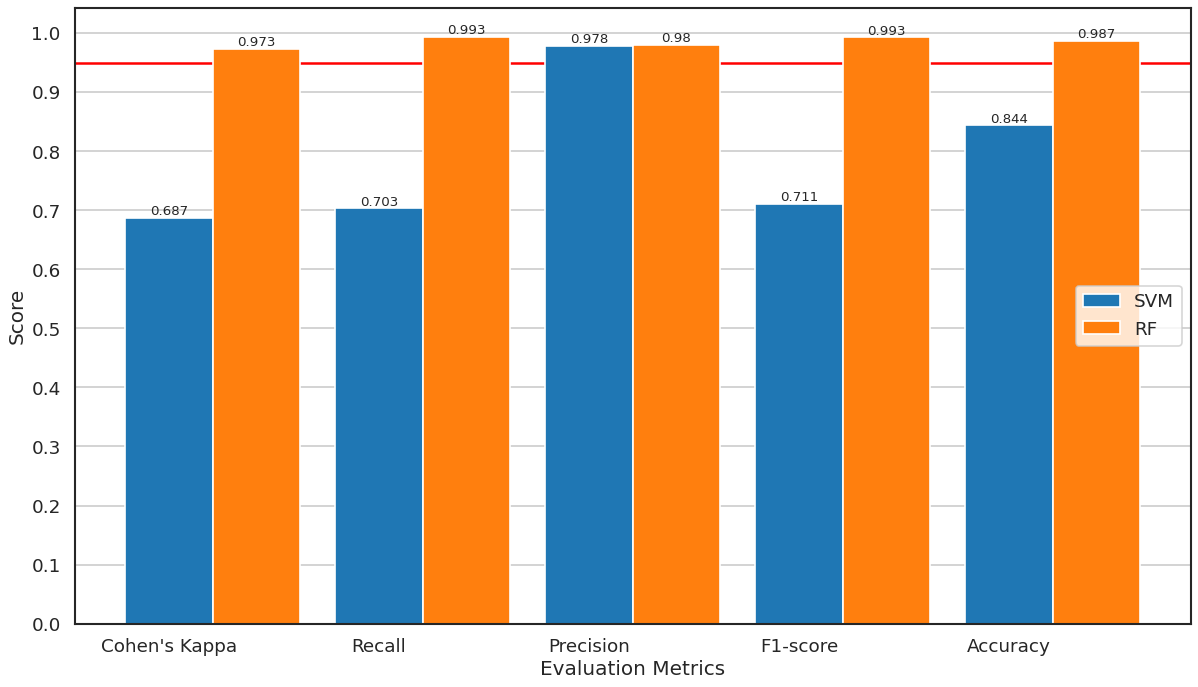

In [29]:
visualize_eval_metrics(results)

In [30]:
wrong_predictions = (y_pred != y_test).sum()
print('Total number of missclassified transactions: {} ({}% of total transactions)'.format(wrong_predictions, round(wrong_predictions/len(y_pred)*100,1)))

# Lets see the cases where we missclassified fraudulent as non-fraudulent
missclassified_fraudulent = (y_pred - y_test).value_counts()[-1]
print('Total number of missclassified fraudulent transactions: {} ({}% of fraudulent transactions, {}% of total transactions)'.format(missclassified_fraudulent, round(missclassified_fraudulent/y_test.value_counts()[1]*100,2), round(missclassified_fraudulent/len(y_pred)*100,2)))

Total number of missclassified transactions: 44 (1.3% of total transactions)
Total number of missclassified fraudulent transactions: 11 (0.67% of fraudulent transactions, 0.33% of total transactions)


Performance on the whole dataset

In [31]:
results_all = []

In [32]:
_, X_test_all, _, y_test_all = train_test_split(X, y, test_size=0.999)

In [33]:
y_pred_all = RF.predict(X_test_all)

result = evaluate(y_test_all, y_pred_all, 'RF all data')
results_all.append(result)

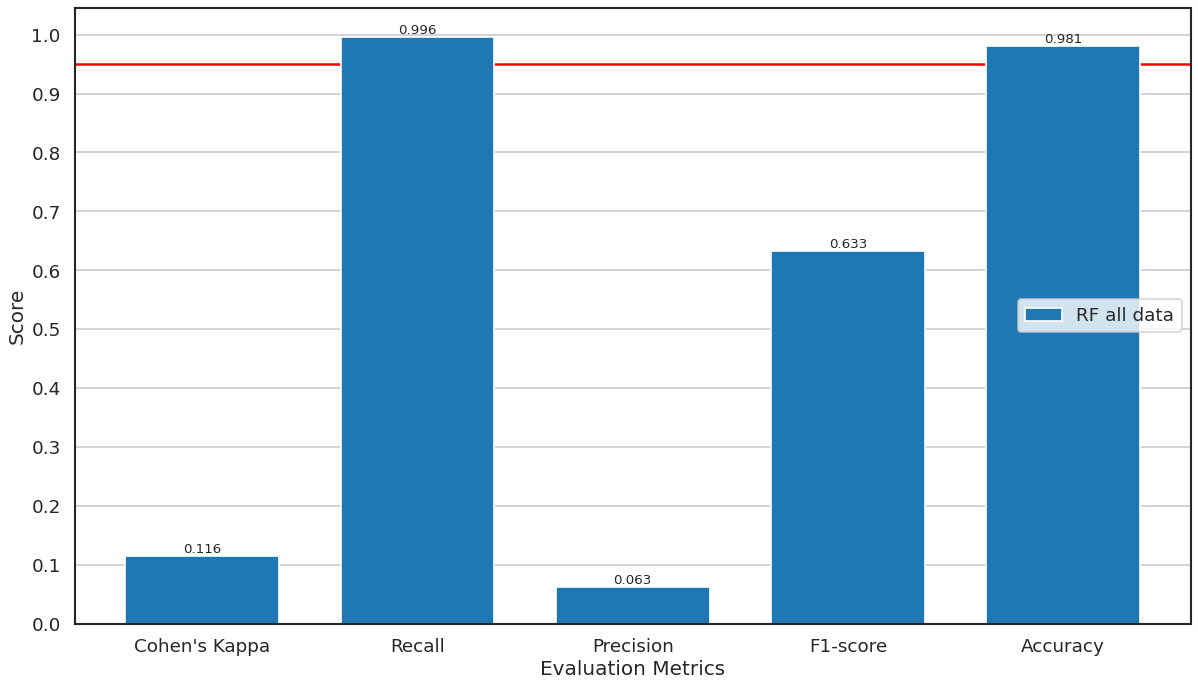

In [34]:
visualize_eval_metrics(results_all)

In [35]:
wrong_predictions_all = (y_pred_all != y_test_all).sum()
print('Total number of missclassified transactions: {} ({}% of total transactions)'.format(wrong_predictions_all, round(wrong_predictions_all/len(y_pred_all)*100,1)))

# Lets see the cases where we missclassified fraudulent as non-fraudulent
missclassified_fraudulent_all = (y_pred_all - y_test_all).value_counts()[-1]
print('Total number of missclassified fraudulent transactions: {} ({}% of fraudulent transactions, {}% of total transactions)'.format(missclassified_fraudulent_all, round(missclassified_fraudulent_all/y_test_all.value_counts()[1]*100,2), round(missclassified_fraudulent_all/len(y_pred_all)*100,4)))

Total number of missclassified transactions: 122435 (1.9% of total transactions)
Total number of missclassified fraudulent transactions: 33 (0.4% of fraudulent transactions, 0.0005% of total transactions)


Lets check the missclassified fraudulent transactions

In [36]:
y_proba = RF.predict_proba(X_test)
y_proba

array([[5.87971294e-03, 9.94120287e-01],
       [9.99695122e-01, 3.04878049e-04],
       [9.92482112e-01, 7.51788759e-03],
       ...,
       [4.87012857e-02, 9.51298714e-01],
       [2.86367007e-03, 9.97136330e-01],
       [1.55733613e-03, 9.98442664e-01]])

In [37]:
# Take the indicies of the missclassified predictions
np.where(y_pred-y_test == -1)

y_proba[np.where(y_pred-y_test == -1)]

array([[0.64912607, 0.35087393],
       [0.6629563 , 0.3370437 ],
       [0.54131824, 0.45868176],
       [0.84291873, 0.15708127],
       [0.81033405, 0.18966595],
       [0.93851668, 0.06148332],
       [0.56295405, 0.43704595],
       [0.62476179, 0.37523821],
       [0.51459553, 0.48540447],
       [0.95263845, 0.04736155],
       [0.97763363, 0.02236637]])

## c. Random Forrest RUS + SMOTE

Lets try to use `SMOTE` to double the size of the minority class and then `RandomUnderSampler` to under-sample to achieve some balance between the classes.

In [38]:
resample_number = y.value_counts()[1]*2
print(resample_number)

16426



It's crucial to apply synthetic oversampling after splitting the dataset into training and testing sets. If we oversample before splitting, there's a risk of artificially inflating the similarity between the training and testing data. This could lead to biased evaluations, as a significant portion of the test data would be synthetically generated and mirror characteristics of the training data.






In [39]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, stratify=y)

In [40]:
y_train2.value_counts()

0    5083526
1       6570
Name: isFraud, dtype: int64

In [41]:
y_test2.value_counts()

0    1270881
1       1643
Name: isFraud, dtype: int64

Testing set has only 18 fraudulent emails. Lets apply `rus2` first and then split.

In [42]:
rus2 = RandomUnderSampler(sampling_strategy=0.5) # 1:2 minority/majority

X_resampled_2, y_resampled_2 = rus2.fit_resample(X, y)

In [43]:
y_resampled_2.value_counts()

0    16426
1     8213
Name: isFraud, dtype: int64

In [44]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled_2, y_resampled_2, test_size=0.2, stratify=y_resampled_2)

In [45]:
y_train2.value_counts()

0    13141
1     6570
Name: isFraud, dtype: int64

In [46]:
y_test2.value_counts()

0    3285
1    1643
Name: isFraud, dtype: int64

Better! Now lets oversample the training data.

In [47]:
resample_number = y_train2.value_counts()[0]
smote_sampler = SMOTE(sampling_strategy={1:resample_number})

In [48]:
X_train_smo, y_train_smo = smote_sampler.fit_resample(X_train2, y_train2)

In [49]:
y_train_smo.value_counts()

1    13141
0    13141
Name: isFraud, dtype: int64

In [50]:
RF_smo = RandomForestClassifier(oob_score=True, random_state=0, warm_start=True, n_jobs=-1, max_depth=10, n_estimators=200, min_samples_leaf=2, min_samples_split=5)
RF_smo.fit(X_train_smo, y_train_smo)
y_pred_2 = RF_smo.predict(X_test2)

result = evaluate(y_test2, y_pred_2, 'RF SMOTE + RUS')
results.append(result)

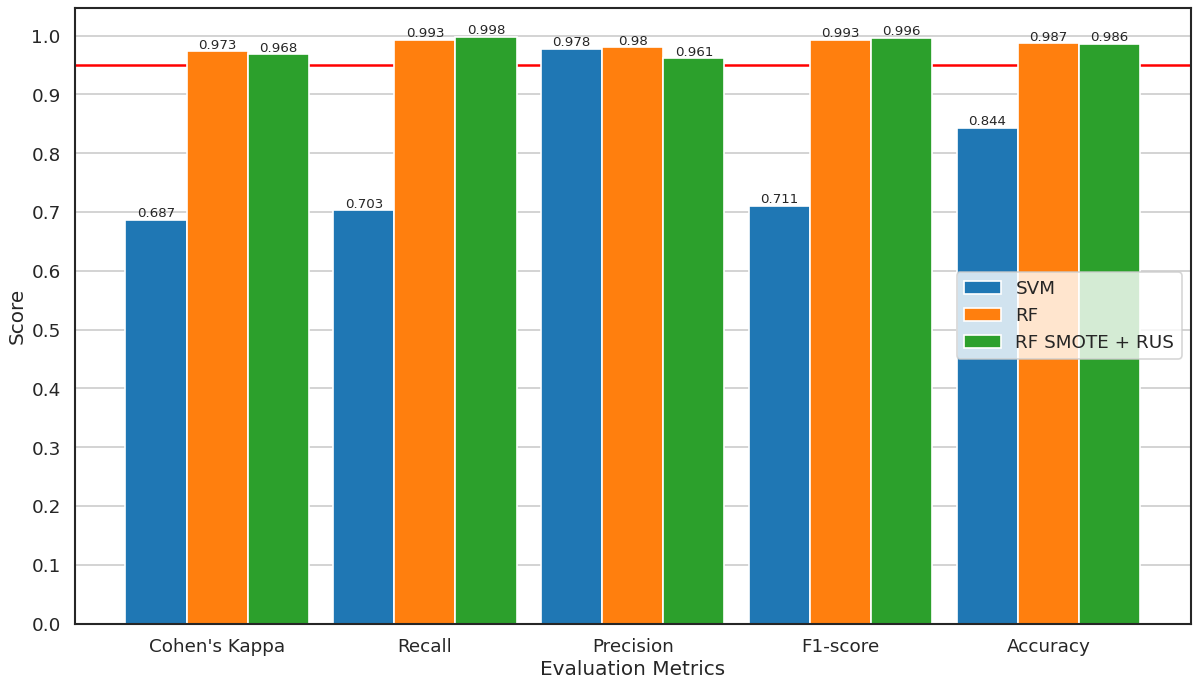

In [51]:
visualize_eval_metrics(results)

In [52]:
wrong_predictions = (y_pred_2 != y_test2).sum()
print('Total number of missclassified transactions: {} ({}% of total transactions)'.format(wrong_predictions, round(wrong_predictions/len(y_pred_2)*100,1)))

# Lets see the cases where we missclassified fraudulent as non-fraudulent
missclassified_fraudulent = (y_pred_2 - y_test2).value_counts()[-1]
print('Total number of missclassified fraudulent transactions: {} ({}% of fraudulent transactions, {}% of total transactions)'.format(missclassified_fraudulent, round(missclassified_fraudulent/y_test2.value_counts()[1]*100,2), round(missclassified_fraudulent/len(y_pred_2)*100,2)))

Total number of missclassified transactions: 70 (1.4% of total transactions)
Total number of missclassified fraudulent transactions: 4 (0.24% of fraudulent transactions, 0.08% of total transactions)


In [53]:
y_pred_all = RF_smo.predict(X_test_all)

result = evaluate(y_test_all, y_pred_all, 'RF SMOTE + RUS all data')
results_all.append(result)

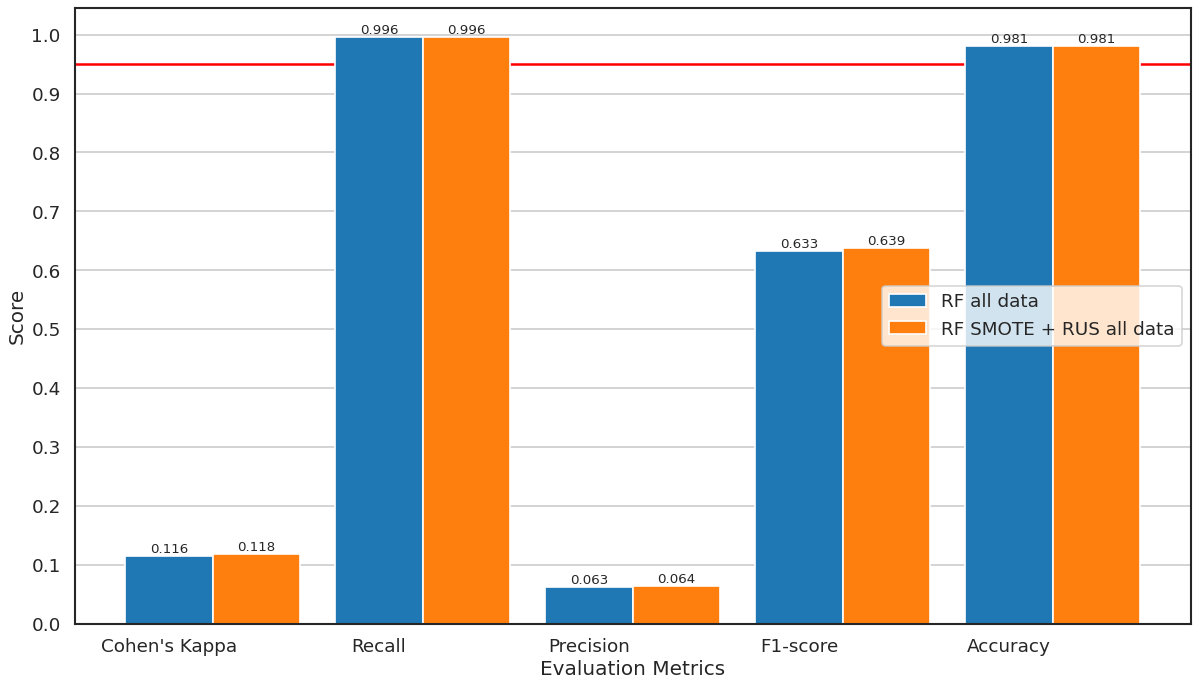

In [54]:
visualize_eval_metrics(results_all)

In [55]:
wrong_predictions_all = (y_pred_all != y_test_all).sum()
print('Total number of missclassified transactions: {} ({}% of total transactions)'.format(wrong_predictions_all, round(wrong_predictions_all/len(y_pred_all)*100,1)))

# Lets see the cases where we missclassified fraudulent as non-fraudulent
missclassified_fraudulent_all = (y_pred_all - y_test_all).value_counts()[-1]
print('Total number of missclassified fraudulent transactions: {} ({}% of fraudulent transactions, {}% of total transactions)'.format(missclassified_fraudulent_all, round(missclassified_fraudulent_all/y_test_all.value_counts()[1]*100,2), round(missclassified_fraudulent_all/len(y_pred_all)*100,4)))

Total number of missclassified transactions: 119418 (1.9% of total transactions)
Total number of missclassified fraudulent transactions: 35 (0.43% of fraudulent transactions, 0.0006% of total transactions)


Lets check the missclassified fraudulent transactions

In [56]:
y_proba = RF_smo.predict_proba(X_test2)
y_proba

array([[6.28451366e-04, 9.99371549e-01],
       [1.00000000e+00, 0.00000000e+00],
       [9.99674627e-01, 3.25373261e-04],
       ...,
       [2.37789803e-02, 9.76221020e-01],
       [9.97840887e-01, 2.15911279e-03],
       [1.35667428e-03, 9.98643326e-01]])

In [57]:
# Take the indicies of the missclassified predictions
np.where(y_pred_2-y_test2 == -1)

(array([1006, 1455, 2472, 3904]),)

In [58]:
y_proba[np.where(y_pred_2-y_test2 == -1)]

array([[0.97460729, 0.02539271],
       [0.83278595, 0.16721405],
       [0.53823838, 0.46176162],
       [0.60992385, 0.39007615]])

## d. Biased Random Forrest RUS + SMOTE

Lets change the threshold of Random Forrest to decrease the number of missclassified fraudulent transactions.

In [59]:
def classify(predictions, threshold):
    prob_class_1 = predictions[:, 1]
    # Classify based on the threshold
    labels = np.where(prob_class_1 >= threshold, 1, 0)
    return labels

In [60]:
y_pred_biased = classify(y_proba, 0.45)

In [61]:
result = evaluate(y_test2, y_pred_biased, 'RF SMOTE + RUS Biased')
results.append(result)

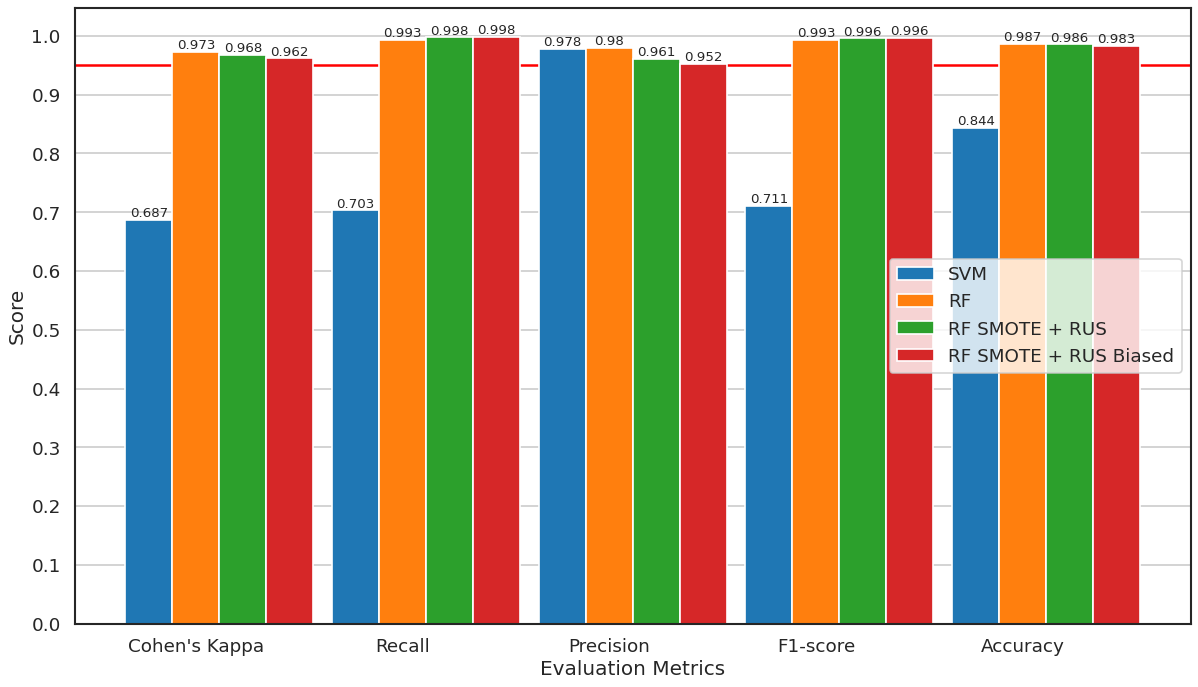

In [62]:
visualize_eval_metrics(results)

In [63]:
wrong_predictions = (y_pred_biased != y_test2).sum()
print('Total number of missclassified transactions: {} ({}% of total transactions)'.format(wrong_predictions, round(wrong_predictions/len(y_pred_biased)*100,1)))

# Lets see the cases where we missclassified fraudulent as non-fraudulent
missclassified_fraudulent = (y_pred_biased - y_test2).value_counts()[-1]
print('Total number of missclassified fraudulent transactions: {} ({}% of fraudulent transactions, {}% of total transactions)'.format(missclassified_fraudulent, round(missclassified_fraudulent/y_test2.value_counts()[1]*100,2), round(missclassified_fraudulent/len(y_pred_biased)*100,2)))

Total number of missclassified transactions: 85 (1.7% of total transactions)
Total number of missclassified fraudulent transactions: 3 (0.18% of fraudulent transactions, 0.06% of total transactions)


In [64]:
y_pred_all_proba = RF_smo.predict_proba(X_test_all)
y_pred_all = classify(y_pred_all_proba, 0.45)

result = evaluate(y_test_all, y_pred_all, 'RF SMOTE + RUS biased all data')
results_all.append(result)

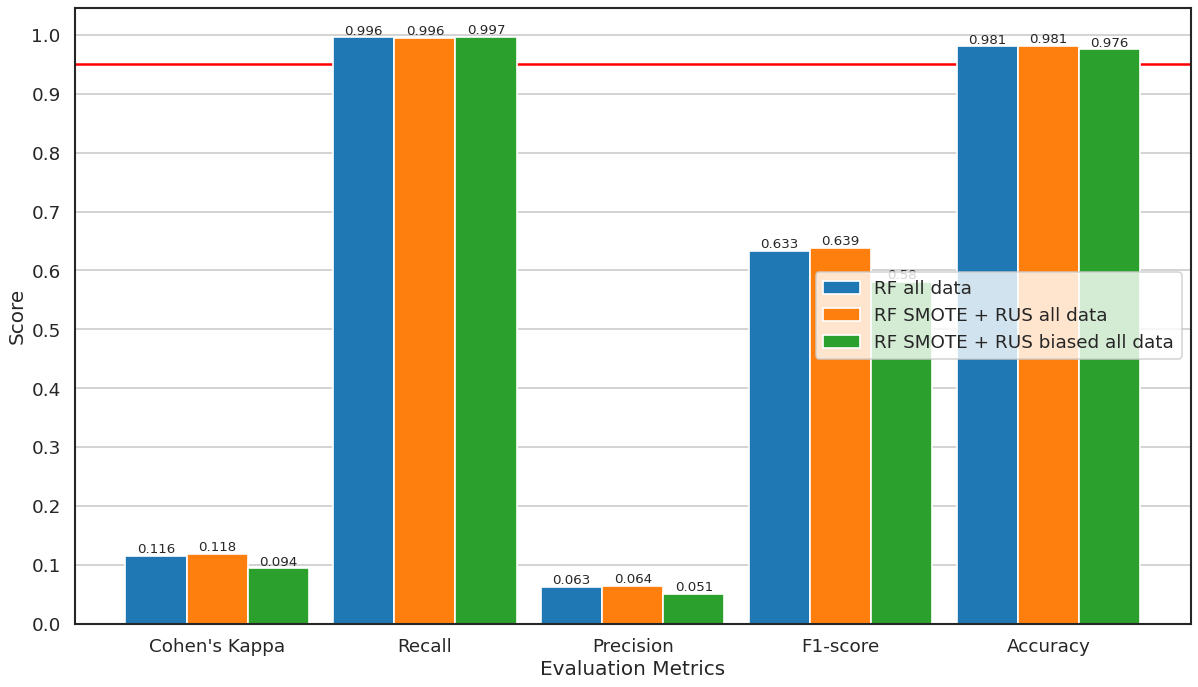

In [65]:
visualize_eval_metrics(results_all)

In [66]:
wrong_predictions_all = (y_pred_all != y_test_all).sum()
print('Total number of missclassified transactions: {} ({}% of total transactions)'.format(wrong_predictions_all, round(wrong_predictions_all/len(y_pred_all)*100,1)))

# Lets see the cases where we missclassified fraudulent as non-fraudulent
missclassified_fraudulent_all = (y_pred_all - y_test_all).value_counts()[-1]
print('Total number of missclassified fraudulent transactions: {} ({}% of fraudulent transactions, {}% of total transactions)'.format(missclassified_fraudulent_all, round(missclassified_fraudulent_all/y_test_all.value_counts()[1]*100,2), round(missclassified_fraudulent_all/len(y_pred_all)*100,4)))

Total number of missclassified transactions: 153196 (2.4% of total transactions)
Total number of missclassified fraudulent transactions: 28 (0.34% of fraudulent transactions, 0.0004% of total transactions)


## e. GradientBoostingClassifier

In [67]:
param_grid_GBC = {'learning_rate': [0.1, 0.01, 0.001, 0.0001],
             'n_estimators' : [2*n+1 for n in range(10)],
             'subsample' : [1.0, 0.5],
             'max_features' : [1, 2, 3, 4]
             }

In [68]:
GR = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid_GBC, scoring='accuracy', cv=5)
GR.fit(X_train2,y_train2)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                         'max_features': [1, 2, 3, 4],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'subsample': [1.0, 0.5]},
             scoring='accuracy')

In [69]:
GBC = GradientBoostingClassifier(n_estimators=GR.best_params_['n_estimators'], learning_rate=GR.best_params_['learning_rate'], subsample=GR.best_params_['subsample'], max_features=GR.best_params_['max_features'], random_state=0)
GBC.fit(X_train, y_train)
y_pred = GBC.predict(X_test)

result = evaluate(y_test, y_pred, 'GBC')
results.append(result)

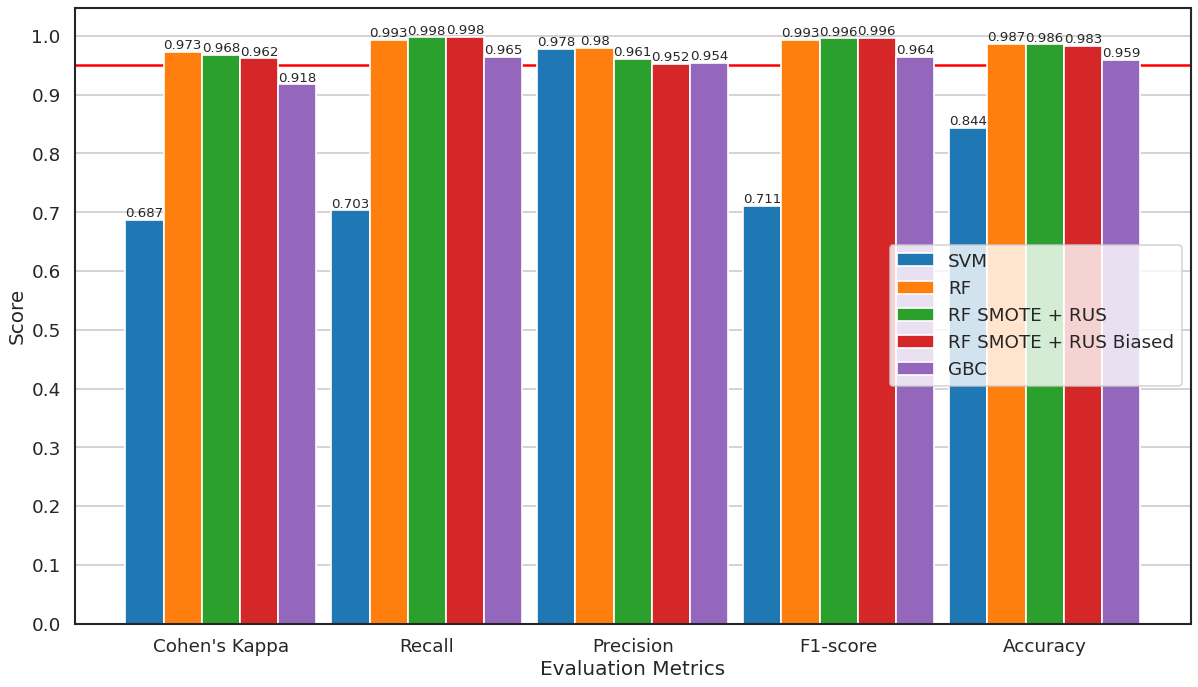

In [70]:
visualize_eval_metrics(results)

In [71]:
wrong_predictions = (y_pred != y_test).sum()
print('Total number of missclassified transactions: {} ({}% of total transactions)'.format(wrong_predictions, round(wrong_predictions/len(y_pred)*100,1)))

# Lets see the cases where we missclassified fraudulent as non-fraudulent
missclassified_fraudulent = (y_pred - y_test).value_counts()[-1]
print('Total number of missclassified fraudulent transactions: {} ({}% of fraudulent transactions, {}% of total transactions)'.format(missclassified_fraudulent, round(missclassified_fraudulent/y_test.value_counts()[1]*100,2), round(missclassified_fraudulent/len(y_pred)*100,2)))

Total number of missclassified transactions: 135 (4.1% of total transactions)
Total number of missclassified fraudulent transactions: 58 (3.53% of fraudulent transactions, 1.77% of total transactions)


# 4. Feature Importance

In [109]:
def visualize_feature_importance(importance_array, title, X_train):
    # Sort the array based on mean value
    sorted_idx = importance_array.importances_mean.argsort()
    # Visualize the feature importances using boxplot
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(10)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title(title)
    plt.show()

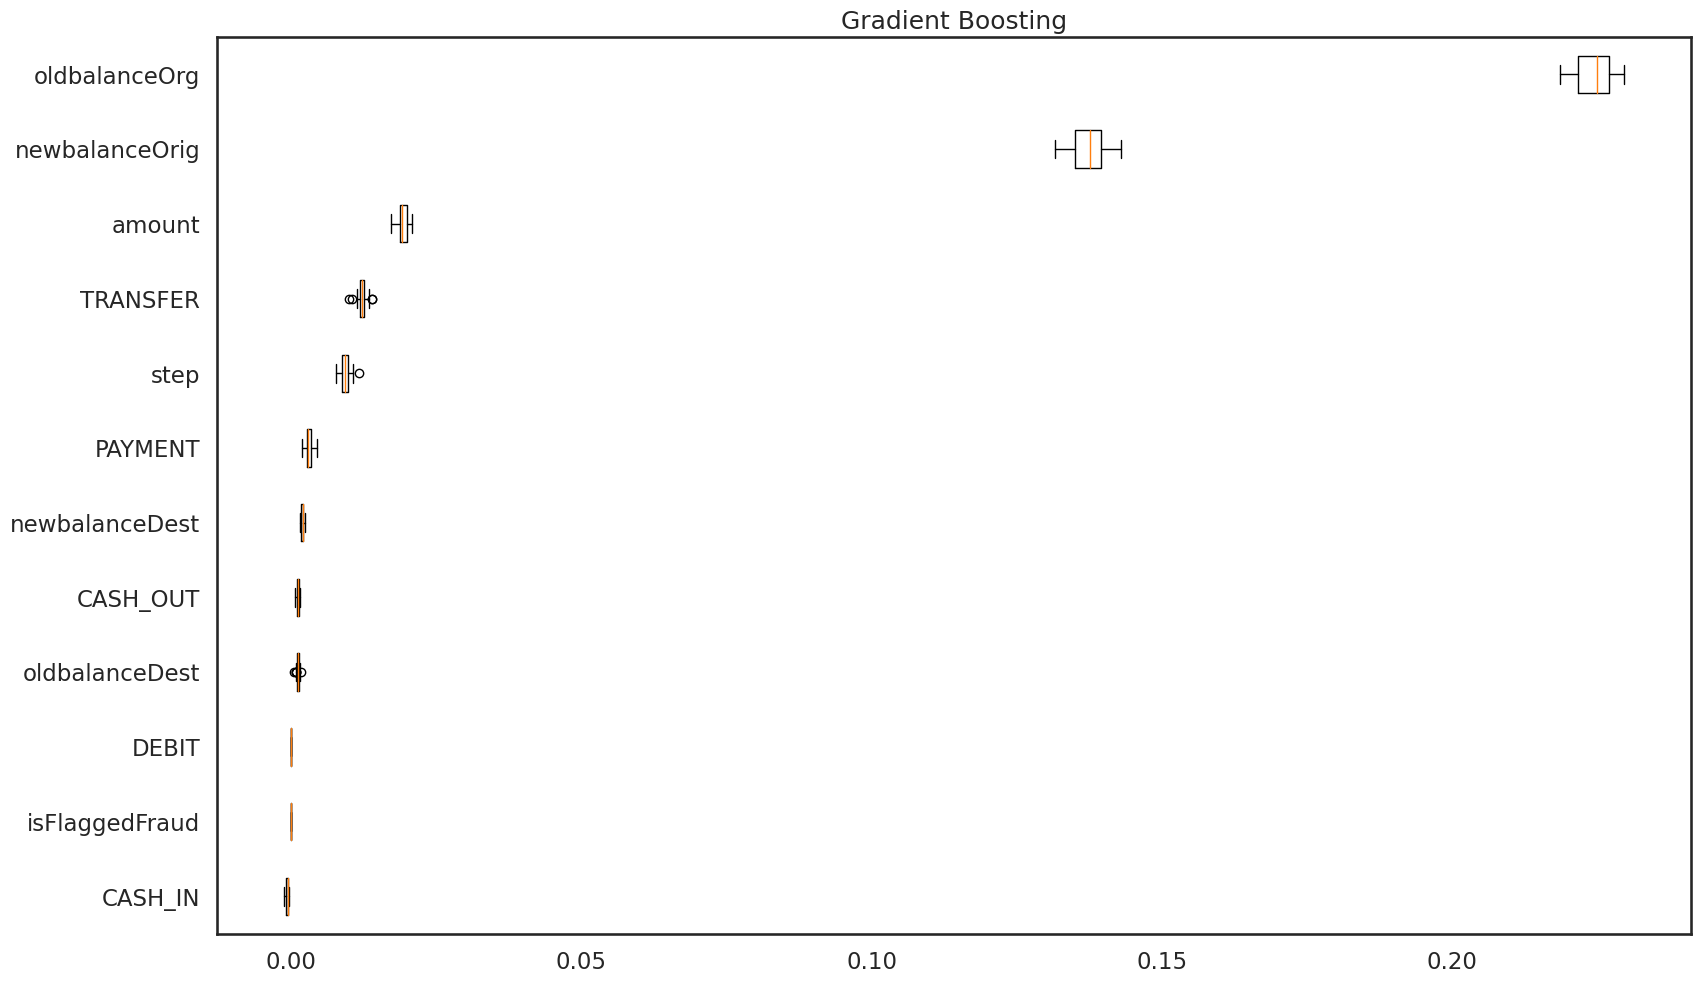

In [73]:
feature_importances = permutation_importance(estimator=GBC, X=X_train, y=y_train, n_repeats=30, random_state=0, n_jobs=2)
visualize_feature_importance(feature_importances, 'Gradient Boosting', X_train)

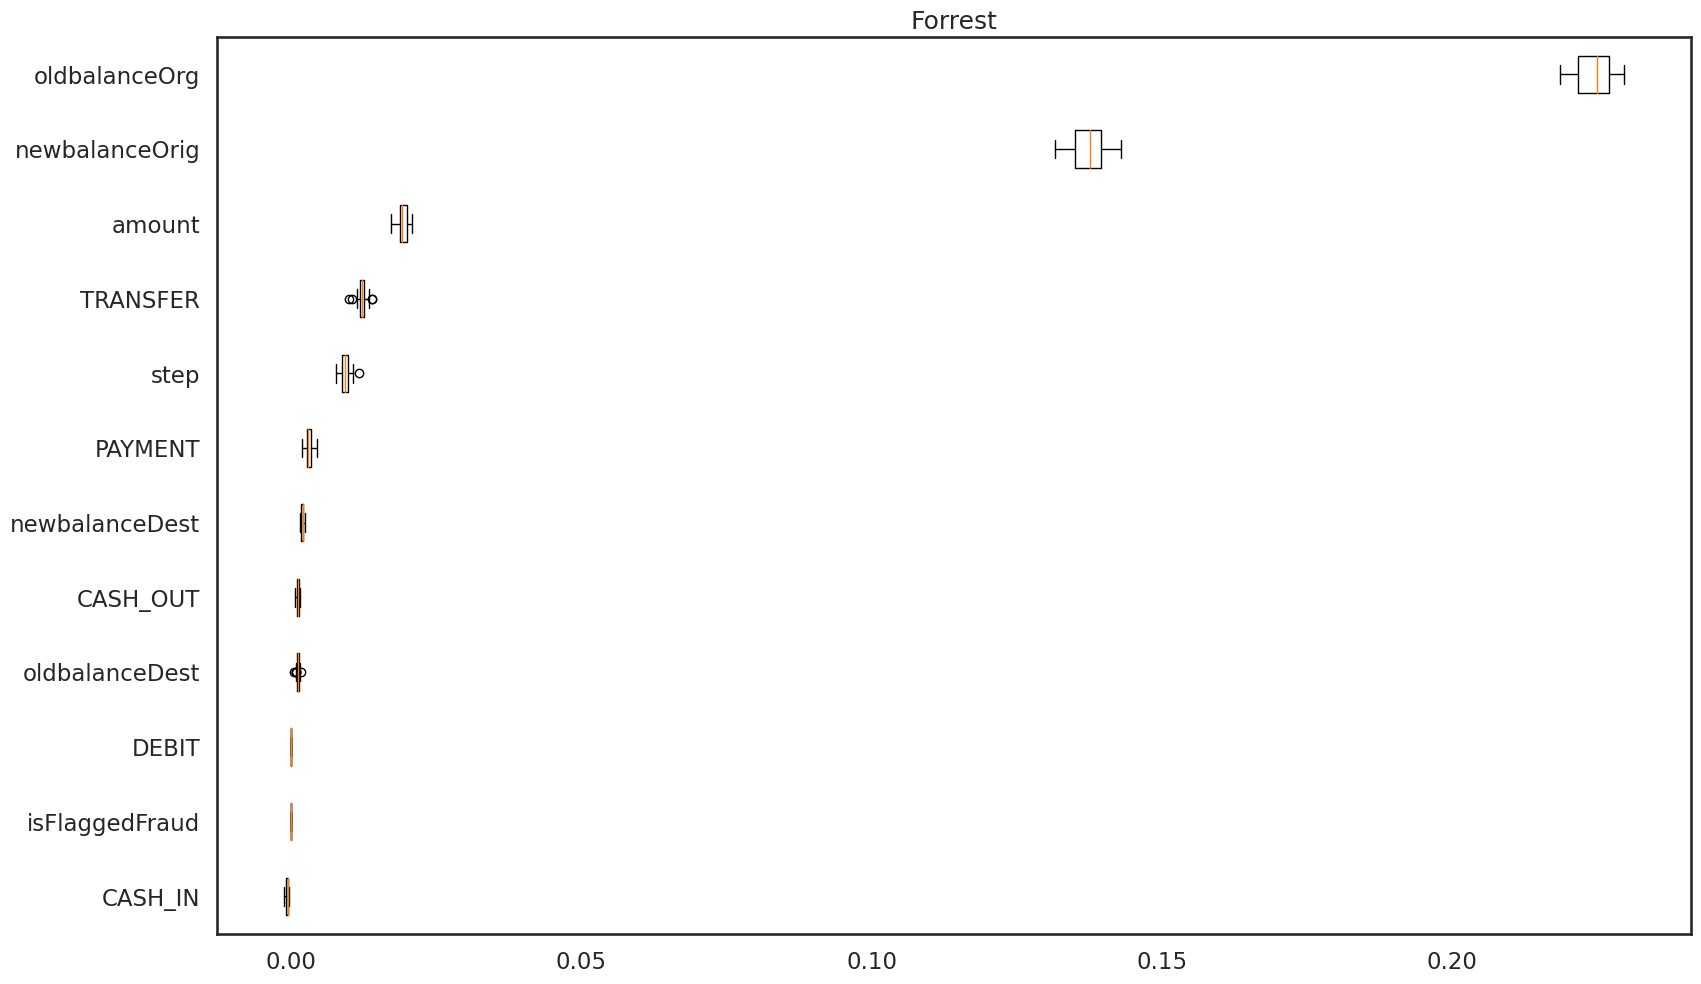

In [74]:
feature_importances = permutation_importance(estimator=GBC, X=X_train, y=y_train, n_repeats=30, random_state=0, n_jobs=2)
visualize_feature_importance(feature_importances, 'Forrest', X_train)

## a. Change input features

In [79]:
X_new = X.copy()
X_new['diffbalanceOrg'] = X_new['newbalanceOrig'] - X_new['oldbalanceOrg']
X_new['diffbalanceDest'] = X_new['newbalanceDest'] - X_new['oldbalanceDest']

In [80]:
X_new

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,diffbalanceOrg,diffbalanceDest
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,1,0,-9839.64,0.00
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,1,0,-1864.28,0.00
2,1,181.00,181.00,0.00,0.00,0.00,0,0,0,0,0,1,-181.00,0.00
3,1,181.00,181.00,0.00,21182.00,0.00,0,0,1,0,0,0,-181.00,-21182.00
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,1,0,-11668.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,0,0,1,0,0,0,-339682.13,339682.13
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,0,0,0,0,0,1,-6311409.28,0.00
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,0,0,1,0,0,0,-6311409.28,6311409.27
6362618,743,850002.52,850002.52,0.00,0.00,0.00,0,0,0,0,0,1,-850002.52,0.00


In [85]:
results = []

In [82]:
X_resampled_new, y_resampled_new = rus.fit_resample(X_new, y)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_resampled_new, y_resampled_new, test_size=0.2, stratify=y_resampled_new)

In [86]:
RF = RandomForestClassifier(oob_score=True, random_state=0, warm_start=True, n_jobs=-1, max_depth=10, n_estimators=200, min_samples_leaf=2, min_samples_split=5)
RF.fit(X_train3, y_train3)
y_pred = RF.predict(X_test3)

result = evaluate(y_test3, y_pred, 'RF new data')
results.append(result)

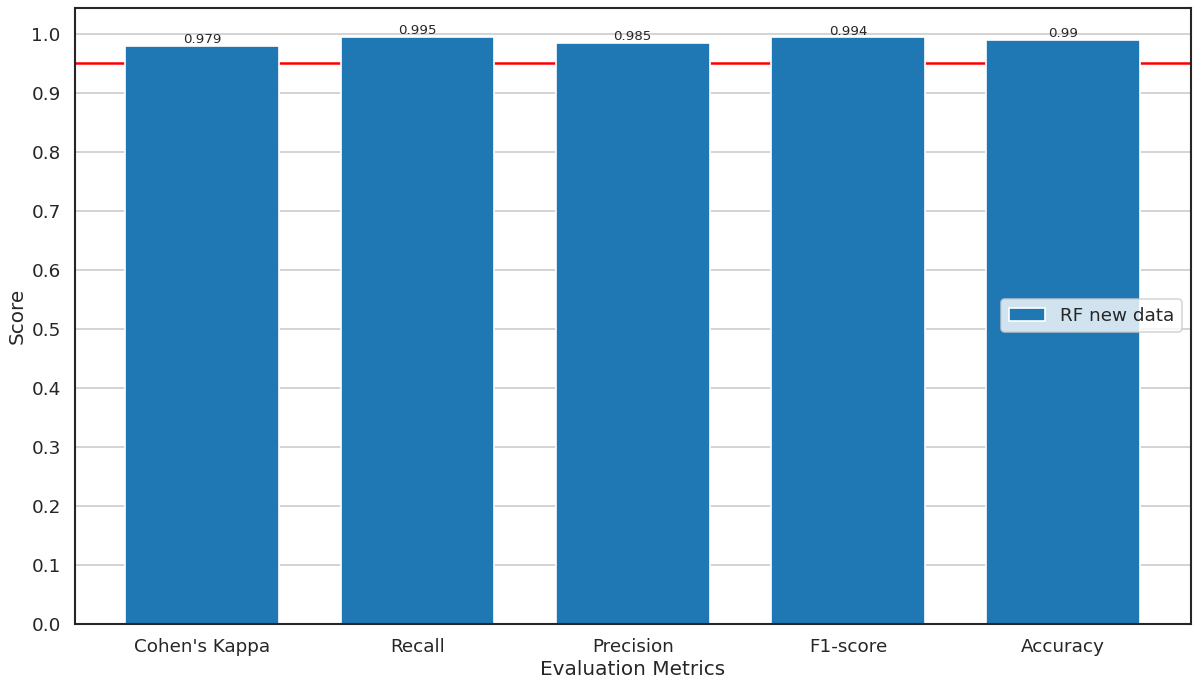

In [87]:
visualize_eval_metrics(results)

In [88]:
wrong_predictions = (y_pred != y_test3).sum()
print('Total number of missclassified transactions: {} ({}% of total transactions)'.format(wrong_predictions, round(wrong_predictions/len(y_pred)*100,1)))

# Lets see the cases where we missclassified fraudulent as non-fraudulent
missclassified_fraudulent = (y_pred - y_test3).value_counts()[-1]
print('Total number of missclassified fraudulent transactions: {} ({}% of fraudulent transactions, {}% of total transactions)'.format(missclassified_fraudulent, round(missclassified_fraudulent/y_test3.value_counts()[1]*100,2), round(missclassified_fraudulent/len(y_pred)*100,2)))

Total number of missclassified transactions: 34 (1.0% of total transactions)
Total number of missclassified fraudulent transactions: 9 (0.55% of fraudulent transactions, 0.27% of total transactions)


## b. RUS + SMOTE

In [89]:
X_resampled_3, y_resampled_3 = rus2.fit_resample(X_new, y)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X_resampled_3, y_resampled_3, test_size=0.2, stratify=y_resampled_3)

resample_number_new = y_train4.value_counts()[0]
smote_sampler2 = SMOTE(sampling_strategy={1:resample_number})

X_train_smo2, y_train_smo2 = smote_sampler2.fit_resample(X_train4, y_train4)

In [91]:
RF_smo2 = RandomForestClassifier(oob_score=True, random_state=0, warm_start=True, n_jobs=-1, max_depth=10, n_estimators=200, min_samples_leaf=2, min_samples_split=5)
RF_smo2.fit(X_train4, y_train4)
y_pred = RF_smo2.predict(X_test4)

result = evaluate(y_test4, y_pred, 'RF new data SMOTE')
results.append(result)

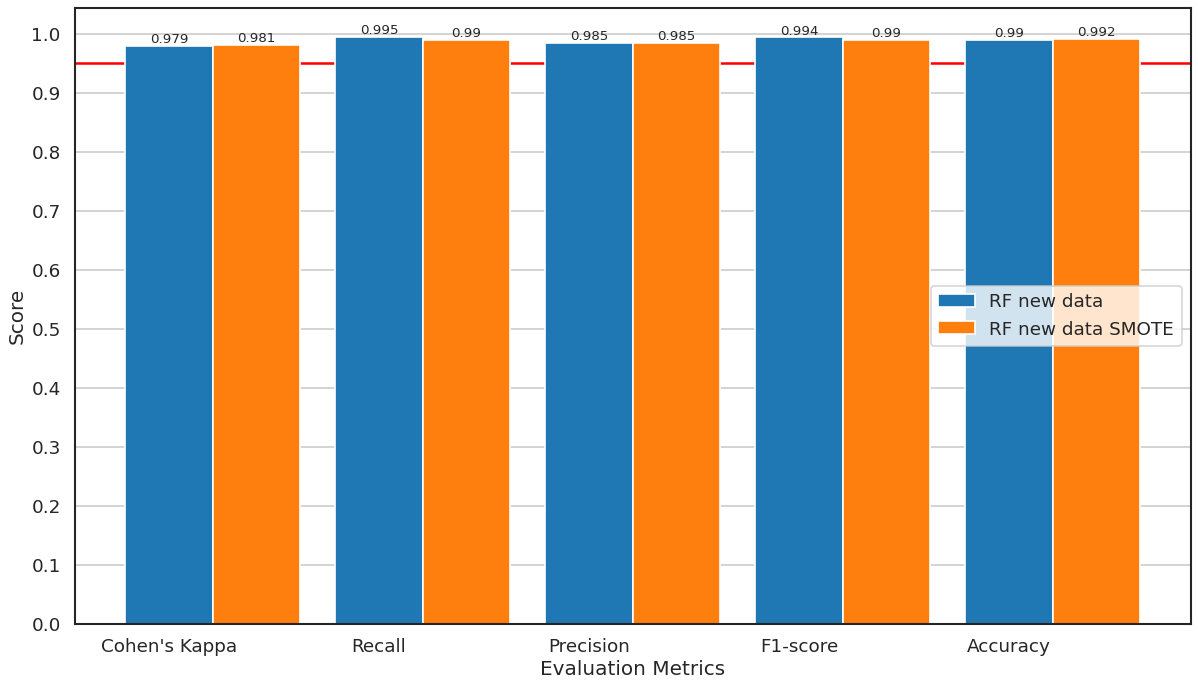

In [92]:
visualize_eval_metrics(results)

In [93]:
wrong_predictions = (y_pred != y_test4).sum()
print('Total number of missclassified transactions: {} ({}% of total transactions)'.format(wrong_predictions, round(wrong_predictions/len(y_pred)*100,1)))

# Lets see the cases where we missclassified fraudulent as non-fraudulent
missclassified_fraudulent = (y_pred - y_test4).value_counts()[-1]
print('Total number of missclassified fraudulent transactions: {} ({}% of fraudulent transactions, {}% of total transactions)'.format(missclassified_fraudulent, round(missclassified_fraudulent/y_test4.value_counts()[1]*100,2), round(missclassified_fraudulent/len(y_pred)*100,2)))

Total number of missclassified transactions: 41 (0.8% of total transactions)
Total number of missclassified fraudulent transactions: 16 (0.97% of fraudulent transactions, 0.32% of total transactions)


In [101]:
X_test4

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,diffbalanceOrg,diffbalanceDest
15062,187,58130.85,10927.00,69057.85,0.00,0.00,0,1,0,0,0,0,58130.85,0.00
9968,398,151592.21,1248655.60,1400247.81,309722.96,158130.75,0,1,0,0,0,0,151592.21,-151592.21
14245,546,124957.41,0.00,0.00,5467852.34,5592809.74,0,0,1,0,0,0,0.00,124957.40
15297,393,522504.25,51178.00,0.00,0.00,522504.25,0,0,1,0,0,0,-51178.00,522504.25
149,16,310126.08,39773.00,349899.08,0.00,0.00,0,1,0,0,0,0,310126.08,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17772,116,2694857.26,2694857.26,0.00,0.00,0.00,0,0,0,0,0,1,-2694857.26,0.00
10498,323,137615.14,22404.00,160019.14,9477580.24,9339965.10,0,1,0,0,0,0,137615.14,-137615.14
9146,305,249607.37,1886613.66,2136221.03,625253.90,375646.54,0,1,0,0,0,0,249607.37,-249607.36
3975,547,9658.79,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0.00,0.00


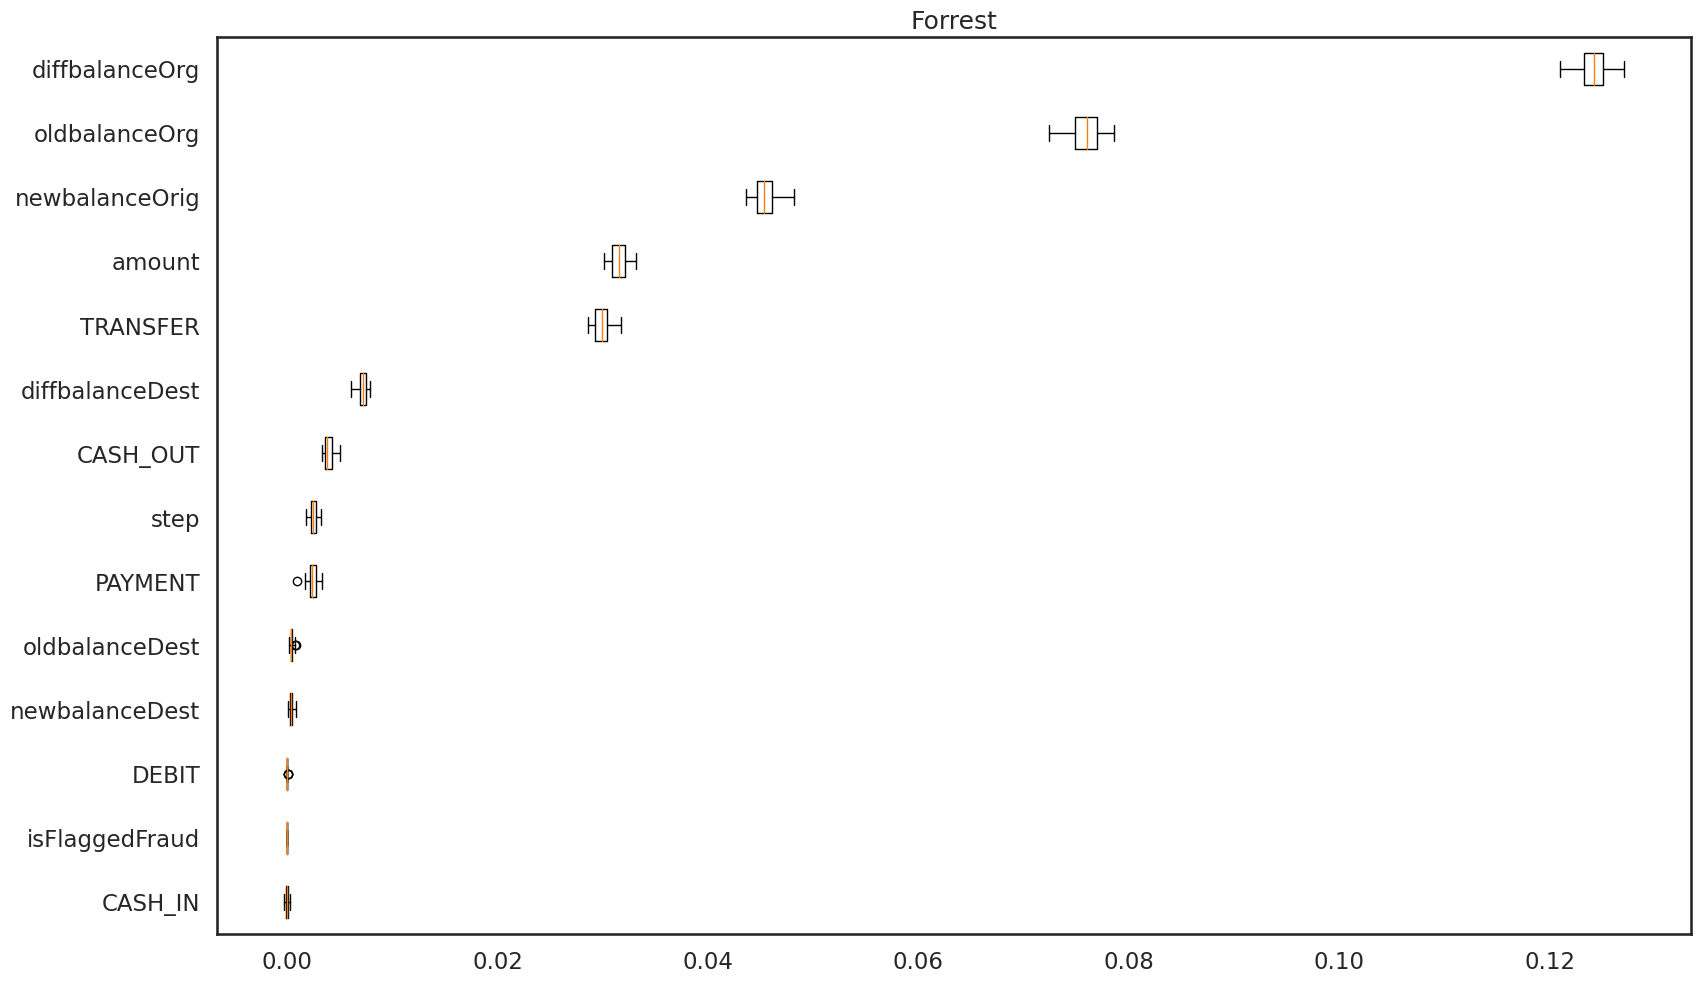

In [110]:
#feature_importances = permutation_importance(estimator=RF_smo2, X=X_train4, y=y_train4, n_repeats=30, random_state=0, n_jobs=2)
visualize_feature_importance(feature_importances, 'Forrest', X_train4)